In [1]:
import importlib
import moc_cart_threaded as MOC

# import moc_cart as MOC
import shapely 
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

In [2]:
from plot_scalar_flux import *

In [3]:
materials = {
    "reflector": MOC.Material(2.0, 1.80, 0.0, "reflector", "blue"),
    "scatterer": MOC.Material(2.0, 1.99, 0.0, "scatterer", "red"),
    "absorber": MOC.Material(10.0, 2.0, 0.0, "absorber", "green"),
    "air": MOC.Material(0.1, 0.006, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "air2": MOC.Material(0.1, 0.09, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "isotropic": MOC.Material(0.1, 0, 1, "isotropic", "purple"),
    "detector": MOC.Material(1.0, 0, 0, "detector", "yellow"),
    "vacuum": MOC.Material(0.0, 0.0, 0.0, "vacuum", "black"),
}

In [4]:
total_dx = 5

def make_blocks(x0, y0, dx=0.1, dy=0.1, total_dx=total_dx, total_dy=total_dx, material=materials["reflector"]):
    """Create a grid of blocks in the x-y plane."""

    if type(material) is str:
        material = materials[material]

    number_blocks_x = int(total_dx / dx)
    assert number_blocks_x == total_dx / dx, "total_dx must be a multiple of dx"
    
    number_blocks_y = int(total_dy / dy)
    assert number_blocks_y == total_dy / dy, "total_dy must be a multiple of dy"

    cells = {}
    for i_block in range(number_blocks_x):
        for j_block in range(number_blocks_y):
            x = x0 + i_block * dx
            y = y0 + j_block * dy
            cell = shapely.geometry.box(x, y, x + dx, y + dy)
            cell_data = MOC.CellData(cell, material)
            cells[cell] = cell_data

    return cells


def plot_mesh(cells):
    # fig, ax = plt.subplots()
    # for cell, cell_data in cells.items():
    #     shapely.plotting.plot_polygon(
    #         cell, color=cell_data.material.color, alpha=0.5, ax=ax
    #     )

    fig, ax = plt.subplots()
    material_handles = {}
    for cell, cell_data in cells.items():
        coords = np.array(cell.exterior.coords)
        polygon = plt.Polygon(
            coords,
            closed=True,
            facecolor=cell_data.material.color,
            alpha=0.5,
            edgecolor="black",
            linewidth=0.03,
        )
        ax.add_patch(polygon)

        mat_name = cell_data.material.name
        if mat_name not in material_handles:
            material_handles[mat_name] = mpatches.Patch(
                facecolor=cell_data.material.color,
                edgecolor="black",
                alpha=0.5,
                label=mat_name,
            )

    ax.autoscale_view()
    ax.set_aspect("equal")

    ax.legend(
        handles=list(material_handles.values()),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")

    return fig, ax

In [5]:
dxs = [0.5, 0.2, 0.1]


def make_mesh(dx=0.1, block_size=2):

    sw = make_blocks(0, 0, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="scatterer")
    se = make_blocks(block_size, 0, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="air")
    nw = make_blocks(0, block_size, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="air")
    ne = make_blocks(block_size, block_size, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="isotropic")
    cells = {**sw, **se, **nw, **ne}
    return cells
# fig, ax = plot_mesh(cells)

In [6]:
def interpolate_to_ref_mesh(solution, reference_mesh):
    """Interpolate the scalar flux from the low resolution mesh to the high resolution mesh."""
    # Extract solution data from the solver
    cell_data = solution.cell_data_list
    centroids = [cell.cell.centroid for cell in cell_data]
    x = [c.x for c in centroids]
    y = [c.y for c in centroids]
    flux = [cell.prior_flux for cell in cell_data]

    ref_points = [
        (cell.cell.centroid.x, cell.cell.centroid.y)
        for cell in reference_mesh.cell_data_list
    ]
    # Linear interpolation
    interpolated_flux = griddata((x, y), flux, ref_points, method="linear")
    # Extrapolate using nearest for nan values
    nan_mask = np.isnan(interpolated_flux)
    if np.any(nan_mask):
        interpolated_flux[nan_mask] = griddata(
            (x, y), flux, np.array(ref_points)[nan_mask], method="nearest"
        )
    return np.array(interpolated_flux).flatten()


In [7]:
ray_width = 0.05/2 
mesh = make_mesh(dx=0.05)
high_res_quad = MOC.ProductQuadrature(64, 64)
high_res_solver = MOC.CartesianMOC(mesh, high_res_quad, bc_west=1, ray_width=ray_width)
high_res_solver.solve()

Generating rays...
Rays generated in 37.95 seconds
Iter 0 error: 113.639013, time: 13.46 seconds
Iter 1 error: 6.346288, time: 12.87 seconds
Iter 2 error: 4.205444, time: 12.92 seconds
Iter 3 error: 3.229437, time: 13.11 seconds
Iter 4 error: 2.626550, time: 13.11 seconds
Iter 5 error: 2.207538, time: 13.20 seconds
Iter 6 error: 1.893253, time: 13.23 seconds
Iter 7 error: 1.644890, time: 13.31 seconds
Iter 8 error: 1.441377, time: 13.19 seconds
Iter 9 error: 1.270352, time: 13.20 seconds
Iter 10 error: 1.124077, time: 13.03 seconds
Iter 11 error: 0.997422, time: 13.17 seconds
Iter 12 error: 0.886802, time: 13.22 seconds
Iter 13 error: 0.789590, time: 13.01 seconds
Iter 14 error: 0.703783, time: 13.12 seconds
Iter 15 error: 0.627798, time: 13.14 seconds
Iter 16 error: 0.560352, time: 13.07 seconds
Iter 17 error: 0.500379, time: 13.11 seconds
Iter 18 error: 0.446981, time: 13.14 seconds
Iter 19 error: 0.399389, time: 12.95 seconds
Iter 20 error: 0.356938, time: 12.94 seconds
Iter 21 erro

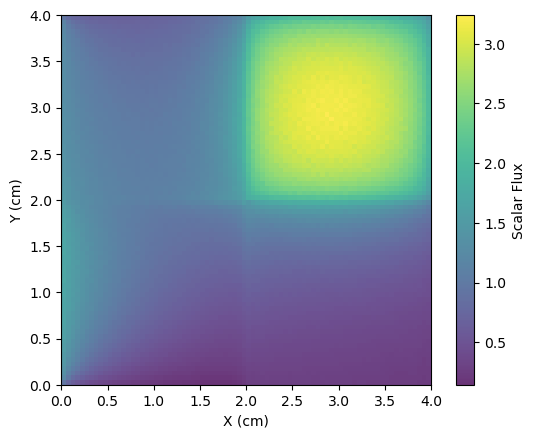

In [8]:
fig = plot_scalar_flux(high_res_solver)
fig.savefig("figures/04_high_res_flux.png", dpi=300, bbox_inches="tight")

In [9]:
angles = [2, 4, 8, 16, 32]

high_res_flux = [cell.prior_flux for cell in high_res_solver.cell_data_list]
number_high_res_cells = len(high_res_flux)

polar_fluxes = {}
l2_polar = {}

for polar_angle in angles:

    quad = MOC.ProductQuadrature(64, polar_angle)

    low_res_solver = MOC.CartesianMOC(mesh, quad, bc_west=1, ray_width=ray_width)
    low_res_solver.solve()
    
    low_res_flux = interpolate_to_ref_mesh(low_res_solver, high_res_solver)

    polar_fluxes[polar_angle] = low_res_flux
    l2_polar[polar_angle] = np.linalg.norm(low_res_flux - high_res_flux) / np.sqrt(number_high_res_cells)

Generating rays...
Rays generated in 38.51 seconds
Iter 0 error: 77.590095, time: 1.07 seconds
Iter 1 error: 6.931061, time: 1.10 seconds
Iter 2 error: 4.513660, time: 1.08 seconds
Iter 3 error: 3.412823, time: 1.08 seconds
Iter 4 error: 2.749370, time: 1.09 seconds
Iter 5 error: 2.292298, time: 1.14 seconds
Iter 6 error: 1.949321, time: 1.11 seconds
Iter 7 error: 1.677308, time: 1.16 seconds
Iter 8 error: 1.453779, time: 1.16 seconds
Iter 9 error: 1.265882, time: 1.12 seconds
Iter 10 error: 1.105619, time: 1.14 seconds
Iter 11 error: 0.967620, time: 1.10 seconds
Iter 12 error: 0.848037, time: 1.11 seconds
Iter 13 error: 0.743965, time: 1.10 seconds
Iter 14 error: 0.653121, time: 1.28 seconds
Iter 15 error: 0.573657, time: 1.14 seconds
Iter 16 error: 0.504043, time: 1.09 seconds
Iter 17 error: 0.442992, time: 1.09 seconds
Iter 18 error: 0.389411, time: 1.10 seconds
Iter 19 error: 0.342358, time: 1.11 seconds
Iter 20 error: 0.301020, time: 1.07 seconds
Iter 21 error: 0.264694, time: 1.0

c:\Users\bpeco\miniconda3\envs\moc\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Rays generated in 38.55 seconds
Iter 0 error: 110.765281, time: 3.94 seconds
Iter 1 error: 6.407196, time: 3.97 seconds
Iter 2 error: 4.218197, time: 3.95 seconds
Iter 3 error: 3.233630, time: 3.85 seconds
Iter 4 error: 2.628335, time: 3.86 seconds
Iter 5 error: 2.208396, time: 3.90 seconds
Iter 6 error: 1.893667, time: 3.90 seconds
Iter 7 error: 1.645056, time: 3.92 seconds
Iter 8 error: 1.441390, time: 3.90 seconds
Iter 9 error: 1.270265, time: 3.87 seconds
Iter 10 error: 1.123922, time: 3.85 seconds
Iter 11 error: 0.997219, time: 3.89 seconds
Iter 12 error: 0.886567, time: 3.86 seconds
Iter 13 error: 0.789333, time: 3.84 seconds
Iter 14 error: 0.703512, time: 3.84 seconds
Iter 15 error: 0.627520, time: 3.88 seconds
Iter 16 error: 0.560071, time: 3.88 seconds
Iter 17 error: 0.500100, time: 3.92 seconds
Iter 18 error: 0.446706, time: 3.86 seconds
Iter 19 error: 0.399120, time: 3.87 seconds
Iter 20 error: 0.356677, time: 3.89 seconds
Iter 21 error: 0.318800, time: 3.88 seconds
Iter 22 

In [10]:
azi_fluxes = {}
l2_azi = {}

for azi_angle in angles:
    quad = MOC.ProductQuadrature(azi_angle, 64)
    low_res_solver = MOC.CartesianMOC(mesh, quad, bc_west=1, ray_width=ray_width)
    low_res_solver.solve()
    low_res_flux = interpolate_to_ref_mesh(low_res_solver, high_res_solver)
    azi_fluxes[azi_angle] = low_res_flux
    l2_azi[azi_angle] = np.linalg.norm(low_res_flux - high_res_flux) / np.sqrt(number_high_res_cells)

Generating rays...
Rays generated in 2.80 seconds
Iter 0 error: 158.039188, time: 0.35 seconds
Iter 1 error: 1.936752, time: 0.34 seconds
Iter 2 error: 0.029270, time: 0.35 seconds
Iter 3 error: 0.000362, time: 0.35 seconds
Iter 4 error: 0.000004, time: 0.34 seconds
Iter 5 error: 0.000000, time: 0.35 seconds
Converged in 5 iterations with error 0.000000
Generating rays...
Rays generated in 2.84 seconds
Iter 0 error: 118.611334, time: 0.94 seconds
Iter 1 error: 10.687159, time: 0.92 seconds
Iter 2 error: 6.614342, time: 0.95 seconds
Iter 3 error: 4.892080, time: 1.02 seconds
Iter 4 error: 3.916507, time: 0.95 seconds
Iter 5 error: 3.271102, time: 0.94 seconds
Iter 6 error: 2.800078, time: 0.94 seconds
Iter 7 error: 2.433156, time: 0.93 seconds
Iter 8 error: 2.134518, time: 0.94 seconds
Iter 9 error: 1.884187, time: 0.99 seconds
Iter 10 error: 1.670147, time: 0.93 seconds
Iter 11 error: 1.484662, time: 0.93 seconds
Iter 12 error: 1.322438, time: 0.93 seconds
Iter 13 error: 1.179648, time

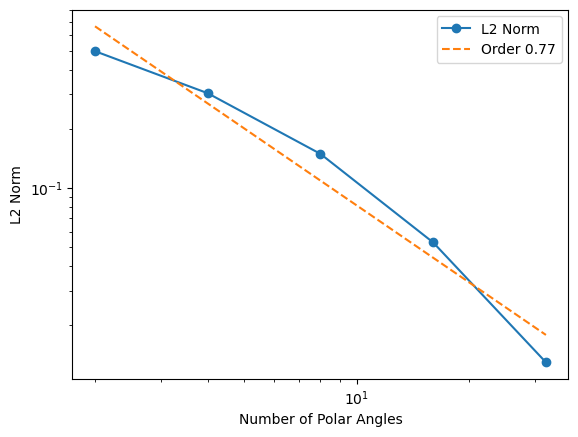

In [12]:
fig, ax = plt.subplots()
x = angles
y = list(l2_polar.values())

ax.plot(x, y, marker="o", label="L2 Norm")
ax.set_yscale("log")
ax.set_xscale("log")

order = np.polyfit(np.log(x), np.log(y), 1)
slope = order[0]
ax.plot(x, np.exp(order[1]) * np.array(x) ** slope, label=f"Order {-1/slope:.2f}", linestyle="--")
ax.legend()
ax.set_xlabel("Number of Polar Angles")
ax.set_ylabel("L2 Norm")

for ext in [".svg", ".pdf"]:
    fig.savefig(f"figures/04_l2_polar{ext}", bbox_inches="tight")

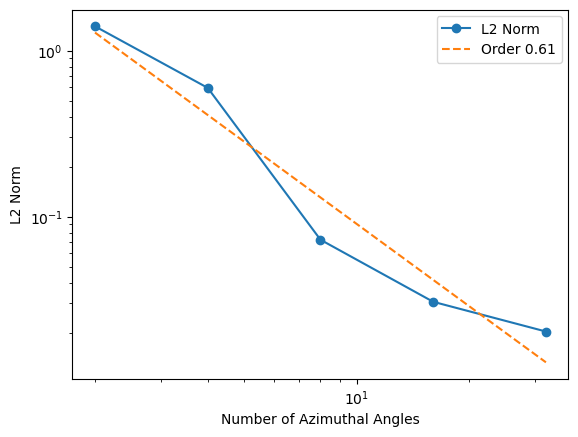

In [13]:
fig, ax = plt.subplots()
x = angles
y = list(l2_azi.values())

ax.plot(x, y, marker="o", label="L2 Norm")
ax.set_yscale("log")
ax.set_xscale("log")

order = np.polyfit(np.log(x), np.log(y), 1)
slope = order[0]
ax.plot(
    x,
    np.exp(order[1]) * np.array(x) ** slope,
    label=f"Order {-1/slope:.2f}",
    linestyle="--",
)
ax.legend()
ax.set_xlabel("Number of Azimuthal Angles")
ax.set_ylabel("L2 Norm")

for ext in [".svg", ".pdf"]:
    fig.savefig(f"figures/04_l2_azi{ext}", bbox_inches="tight")